In [12]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import saliency.core as saliency
import torch
from matplotlib import pylab as P
from torchvision import models, transforms
from tqdm import tqdm
from transformers import (
    AutoImageProcessor,
    BeitForImageClassification,
    ConvNextForImageClassification,
    ResNetForImageClassification,
    SwinForImageClassification,
    Trainer,
    TrainingArguments,
    ViTFeatureExtractor,
    ViTForImageClassification,
)

from cracks_classification_hf import transform
from datasets import load_dataset
from saliency_utils import ShowHeatMap, ShowImage


In [13]:

model_type = "resnet"
dataset = load_dataset("imagefolder", data_dir="datasets/cracks_classification")
labels = dataset["train"].features["label"].names
model_name_or_path = "google/vit-base-patch16-224-in21k"
feature_extractor_vit = ViTFeatureExtractor.from_pretrained("vit-cracks")
feature_extractor_resnet = AutoImageProcessor.from_pretrained("resnet-cracks")
feature_extractor_convnext = AutoImageProcessor.from_pretrained("convnext-cracks")
feature_extractor_swin = AutoImageProcessor.from_pretrained("swin-cracks")
feature_extractor_beit = AutoImageProcessor.from_pretrained("beit-cracks")

model_resnet = ResNetForImageClassification.from_pretrained(
    "resnet-cracks",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

model_convnext = ConvNextForImageClassification.from_pretrained(
    "convnext-cracks",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

if model_type == "resnet":
    feature_extractor = feature_extractor_resnet
    model = model_resnet
elif model_type == "convnext":
    feature_extractor = feature_extractor_convnext
    model = model_convnext

model.eval()

Resolving data files: 100%|██████████| 581/581 [00:00<00:00, 772390.06it/s]
Found cached dataset imagefolder (/home/yoni/.cache/huggingface/datasets/imagefolder/default-440e4421f451e3be/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 2/2 [00:00<00:00, 174.62it/s]
Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at convnext-cracks and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [14]:

def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx = call_model_args["class_idx_str"]
    model = call_model_args["model"]
    images = np.transpose(images, (0, 3, 1, 2))
    images = torch.tensor(images, dtype=torch.float32)
    images.requires_grad_(True)
    output = model(images).logits
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:, target_class_idx]
        grads = torch.autograd.grad(
            outputs, images, grad_outputs=torch.ones_like(outputs)
        )
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

    print("Method not supported")
    return {}

In [15]:
image_example = PIL.Image.open("datasets/finetune/crack/images/4.png")


In [16]:
patch_size = 64
nb_x_steps = image_example.size[0]//(patch_size//2) -1
nb_y_steps = image_example.size[1]//(patch_size//2) -1

positive_patches = []

for x in tqdm(range(nb_x_steps)):
    for y in range(nb_y_steps):
        left = x*(patch_size//2)
        top = y*(patch_size//2)
        right = left + patch_size
        bottom = top + patch_size
        patch = image_example.crop((left, top, right, bottom))
        patch_transformed = transform({"image":[patch], "label":[0]}, feature_extractor)
        output = model(patch_transformed["pixel_values"]).logits
        predicted_class_idx = torch.argmax(output).item()
        predicted_class = labels[predicted_class_idx]
        if predicted_class == "positive":
            positive_patches.append((left, top))


100%|██████████| 39/39 [00:34<00:00,  1.13it/s]


In [17]:
print(len(positive_patches))
print(nb_x_steps*nb_y_steps)

15
819


In [18]:
heatmap_result = np.zeros((image_example.size[1], image_example.size[0]))

In [19]:
call_model_args = {"class_idx_str": 1, "model": model}

# Construct the saliency object. This alone doesn't do anthing.

gradient_saliency = saliency.GradientSaliency()
integrated_gradients = saliency.IntegratedGradients()

    # Baseli

In [23]:
saliency_type = "integrated_gradients"

In [24]:
for x, y in tqdm(positive_patches):
    model.zero_grad()
    patch = image_example.crop((x, y, x+patch_size, y+patch_size))
    patch_transformed = transform({"image":[patch], "label":[0]}, feature_extractor)
    input = patch_transformed["pixel_values"][0].permute((1, 2, 0)).numpy()

    if saliency_type == "smoothgrad":
        smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(
            input, call_model_function, call_model_args
        )
        smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)
    elif saliency_type == "integrated_gradients":
        baseline = np.zeros(input.shape)
        smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
            input,
            call_model_function,
            call_model_args,
            x_steps=10,
            x_baseline=baseline,
            batch_size=20,
        )

        # Call the visualization methods to convert the 3D tensors to 2D grayscale.
        # vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
        smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(
            smoothgrad_integrated_gradients_mask_3d
        )
    #resize to 64x64
    smoothgrad_mask_grayscale_resized = np.array(PIL.Image.fromarray(smoothgrad_mask_grayscale).resize((patch_size, patch_size)))
    heatmap_result[y:y+patch_size, x:x+patch_size] += smoothgrad_mask_grayscale_resized
    
    

100%|██████████| 15/15 [03:33<00:00, 14.26s/it]


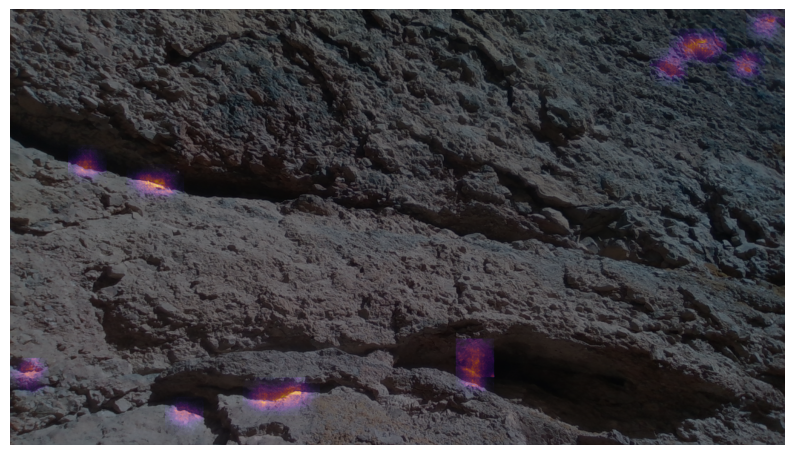

In [25]:
P.figure(figsize=(10, 10))
P.axis("off")
P.imshow(image_example)
P.imshow(heatmap_result, cmap="inferno", alpha=0.5)